# Policy Gradients on CartPole with PyTorch 1.0

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [0]:
env = gym.make('CartPole-v1')
env.seed(1)
torch.manual_seed(1)

# Hyperparameters
learning_rate = 0.01
gamma = 0.99

# Define model and training loop

In [0]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128

        self.l1 = nn.Linear(state_space, num_hidden, bias=False)
        self.l2 = nn.Linear(num_hidden, action_space, bias=False)

        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        self.reset()

    def reset(self):
        # Episode policy and reward history
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)


class Value(nn.Module):
    def __init__(self):
        super(Value, self).__init__()
        state_space = env.observation_space.shape[0]
        num_hidden = 128

        self.l1 = nn.Linear(state_space, num_hidden, bias=False)
        self.l2 = nn.Linear(num_hidden, 1, bias=False)

    def forward(self, x):
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.l2,
        )
        return model(x)


def predict(state):
    # Select an action (0 or 1) by running policy model
    # and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    action_probs = policy(state)
    distribution = Categorical(action_probs)
    action = distribution.sample()

    # Add log probability of our chosen action to our history
    policy.saved_log_probs.append(distribution.log_prob(action))
    
    return action


def update_policy(replay):
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns).float().to(device)
    states = torch.tensor([state for state, _, _ in replay], dtype=torch.float, device=device)
    vals = value(states).squeeze(1) 
    if not math.isnan(returns.std()):
        returns = (returns - returns.mean()) / \
            (returns.std() + np.finfo(np.float32).eps)
    with torch.no_grad():
        advantage = returns - vals

    for log_prob, R in zip(policy.saved_log_probs, advantage):
        policy_loss.append(-log_prob * R)

    optimizer.zero_grad()
    policy_loss = torch.stack(policy_loss).sum().to(device)
    policy_loss.backward()
    optimizer.step()

    val_optimizer.zero_grad()
    F.mse_loss(vals, returns).backward()
    val_optimizer.step()

    # Save and intialize episode history counters
    policy.loss_history.append(policy_loss.item())
    policy.reward_history.append(np.sum(policy.rewards))
    policy.reset()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


def train(episodes):
    scores = []
    replay = []
    for episode in range(episodes):
        # Reset environment and record the starting state
        state = env.reset()

        for time in range(1000):
            action = predict(state)

            # Uncomment to render the visual state in a window
            # env.render()

            # Step through environment using chosen action
            next_state, reward, done, _ = env.step(action.item())
            replay.append((state, action, reward))
            state = next_state

            # Save reward
            policy.rewards.append(reward)
            if done:
                break

        update_policy(replay)
        replay = []
        # Calculate score to determine when the environment has been solved
        scores.append(time)
        mean_score = np.mean(scores[-100:])

        if episode % 50 == 0:
            print('Episode {}\tAverage length (last 100 episodes): {:.2f}'.format(
                episode, mean_score))

        if mean_score > env.spec.reward_threshold:
            print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
                  .format(episode, mean_score, time))
            break

# Start training

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
policy = Policy().to(device)
value = Value().to(device)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
val_optimizer = optim.Adam(value.parameters(), lr=learning_rate)
train(episodes=1000)

Episode 0	Average length (last 100 episodes): 28.00
Episode 50	Average length (last 100 episodes): 109.27
Episode 100	Average length (last 100 episodes): 176.67
Episode 150	Average length (last 100 episodes): 335.14
Episode 200	Average length (last 100 episodes): 452.68
Solved after 220 episodes! Running average is now 476.81. Last episode ran to 499 time steps.


# Plot training performance

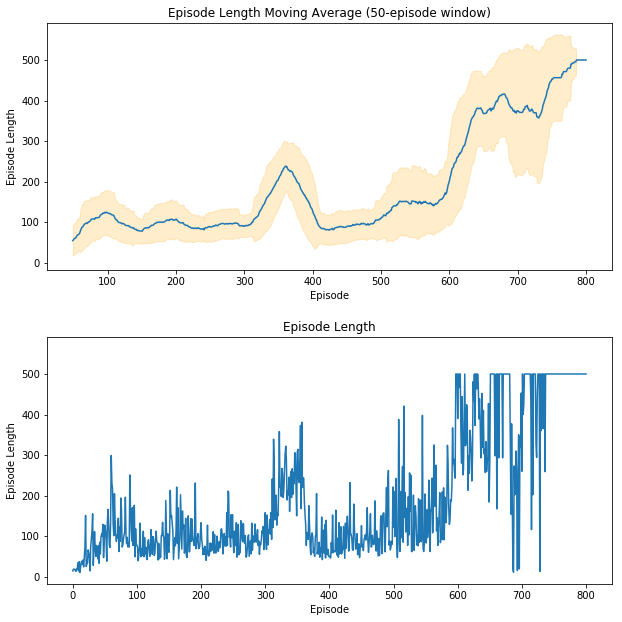

In [5]:
# number of episodes for rolling average
window = 50

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()